# Competitive Auctions on eBay.com

## eBay.com의 경쟁적인 경매

- [eBayAuction.csv] 파일에는 2004년 5~6월에 eBay.com에서 거래된 총 1,972건의 경매 정보가 담겨 있다. 분석 목적은 이 데이터를 사용해 경쟁적인 경매와 비경쟁적인 경매를 구분하는 모델을 구축하는 것이다.

- 경쟁적인 경매는 경매되고 있는 물품에 대해 최소한 2개 이상의 입찰이 있는 경매로 정의된다. 데이터는 물품을 나타내는 변수(경매 범주), 판매자 등급(eBay 등급), 판매자가 선택한 경매 조건(경매 기간, 시작가(OpenPrice), 화폐 단위, 경매 마감 요일)을 포함한다. 경매가 마감된 가격(ClosePrice)에 대한 데이터도 있다. 분석 목표는 경매가 경쟁적인지 아닌지를 예측하는 것이다.

- 데이터 전처리: 범주형 예측 변수들에 대해서 더미 변수를 생성하시오. 범주형 변수에는 물품 항목(Category: 18개 범주), 화폐 단위(currency: US, GBP, EUR), 경매 종료일(endDay: 월요일~일요일), 경매 기간(Duration: 1, 3, 5, 7, 10일)이 포함된다.

In [1]:
'''
eBayAuctions.csv파일을 읽어 DataFrame 생성
'''
import pandas as pd

eBayAuctions_df = pd.read_csv('../data/eBayAuctions.csv')
eBayAuctions_df

,Category,currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
...,...,...,...,...,...,...,...,...
1967,Automotive,US,2992,5,Sun,359.95,359.95,0
1968,Automotive,US,21,5,Sat,610.00,300.00,1
1969,Automotive,US,1400,5,Mon,549.00,549.00,0
1970,Automotive,US,57,7,Fri,820.00,650.00,1


/tmp/ipykernel_360516/2452744367.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(set(extracted_df[col]), rotation=45, ha='right')
/tmp/ipykernel_360516/2452744367.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


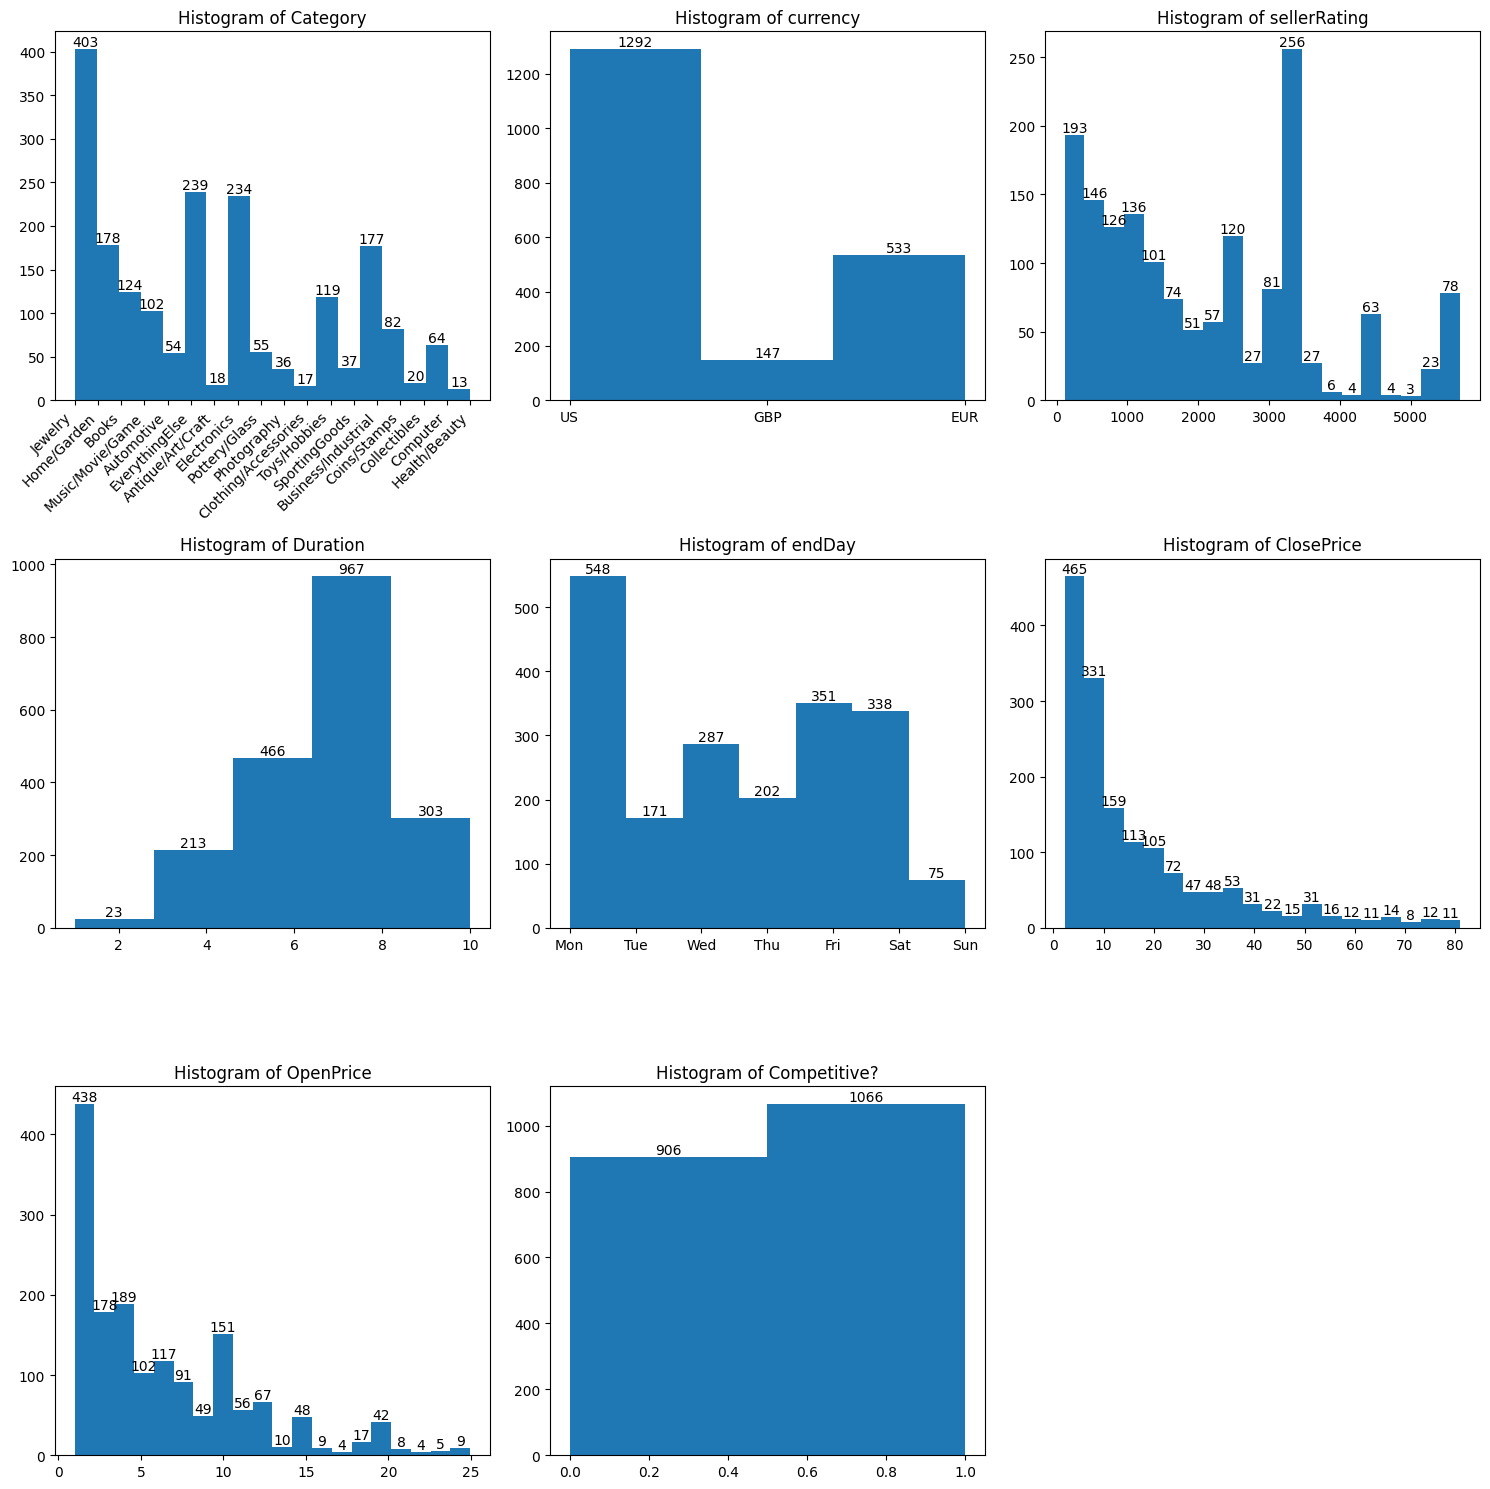

In [2]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import dmba
import numpy as np

num_col = 3
num_row = 3
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(num_col, num_row, figure=fig)

for idx, col in enumerate(eBayAuctions_df.columns):

    ax = fig.add_subplot(gs[idx//num_col, idx%num_row])
    ax.set_title(f"Histogram of {col}")
        
    if col in ['sellerRating', 'ClosePrice', 'OpenPrice']:  # 분포가 큰 columns
        bins = 20
        q1 = eBayAuctions_df[col].quantile(0.1) # 하위 10% 값
        q3 = eBayAuctions_df[col].quantile(0.9) # 상위 90% 값
        extracted_df = eBayAuctions_df[(eBayAuctions_df[col] >= q1) & (eBayAuctions_df[col] <= q3)] # 10~90%만 추출

    else:  # 분포가 작은 columns
        bins = len(set(eBayAuctions_df[col]))
        extracted_df = eBayAuctions_df

    counts, bins, patches = ax.hist(extracted_df[col].dropna(), bins=bins)

    # x축 라벨 형식 변경
    if col in ['Category']:
        ax.set_xticklabels(set(extracted_df[col]), rotation=45, ha='right')

    elif col in ['endDay']:
        ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

    for count, patch in zip(counts, patches):   # 각 bin의 count 수 표시
        x = patch.get_x() + patch.get_width() / 2
        y = count
        ax.text(x, y, f"{int(count)}", ha='center', va='bottom', fontsize=10, color='black')

fig.tight_layout()




In [3]:
'''
범주형 예측 변수들에 대해서 더비 변수 생성
범주형 변수: Category, currency, endDay, Duration
'''

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from dmba.metric import AIC_score

# eBayAuctions_df = dmba.load_data('eBayAuctions.csv')

# convert to categorical
eBayAuctions_df.Category = eBayAuctions_df.Category.astype('category')
eBayAuctions_df.currency = eBayAuctions_df.currency.astype('category')
eBayAuctions_df.Duration = eBayAuctions_df.Duration.astype('category')
eBayAuctions_df.endDay = eBayAuctions_df.endDay.astype('category')

predictors = ['Category', 'currency', 'Duration', 'endDay', 'ClosePrice', 'OpenPrice']
outcome = 'Competitive?'

X = pd.get_dummies(eBayAuctions_df[predictors])
y = eBayAuctions_df[outcome]

# split into training and validation
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4,
                                                      random_state=1)

logit_full = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_full.fit(train_X, train_y)

pd.set_option('display.width', 95)
pd.set_option('display.precision',3)
pd.set_option('display.max_columns', 50)
print('intercept ', logit_full.intercept_[0])

print(pd.DataFrame({'coeff': logit_full.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_full.predict(valid_X), df=len(train_X.columns) + 1))
pd.reset_option('display.width')
pd.reset_option('display.precision')
pd.reset_option('display.max_columns')

intercept  -0.05696995208052439
       ClosePrice  OpenPrice  Category_Antique/Art/Craft  Category_Automotive  \
coeff       0.091     -0.108                       0.146               -0.544   

       Category_Books  Category_Business/Industrial  Category_Clothing/Accessories  \
coeff           0.331                         1.309                         -1.284   

       Category_Coins/Stamps  Category_Collectibles  Category_Computer  Category_Electronics  \
coeff                 -2.073                 -0.028             -0.078                 0.479   

       Category_EverythingElse  Category_Health/Beauty  Category_Home/Garden  \
coeff                   -1.467                  -1.787                -0.001   

       Category_Jewelry  Category_Music/Movie/Game  Category_Photography  \
coeff            -0.676                      0.165                 5.667   

       Category_Pottery/Glass  Category_SportingGoods  Category_Toys/Hobbies  currency_EUR  \
coeff                  -0.153  

* Category : 'Antique/Art/Craft'는 가장 경쟁적인 항목이며, 'Coins/Stamps'는 가장 덜 경쟁적인 항목이다.
* currency : 'GBP'는 가장 경쟁적인 통화이며, 'EUR'는 가장 덜 경쟁적인 통화이다.
* Duration : '5일'은 가장 경쟁적인 기간이며, '1일'은 가장 덜 경쟁적인 기간이다.
* endDay   : 'Mon'는 가장 경쟁적인 마감일이며, 'Wed'는 가장 덜 경쟁적인 마감일이다.


---
- 다양한 범주형 변수들(더미 변수가 아닌 원래 변수 사용)의 함수로서 이진형 결과 변수(경쟁적인 경매 여부)의 평균을 구하기 위해 피벗 테이블을 작성하시오. 모델에서 사용될 더미 변수의 개수를 줄이기 위해서 피벗 테이블의 정보를 활용하시오. 예를 들어, 경쟁적인 경매의 분포가 유사한 범주는 합칠 수 있다.

## Category(카테고리)
[eBay.com - Category](https://www.ebay.com/n/all-categories)

- Antique/Art/Craft      앤틱/미술/공예   
- Automotive             자동차   
- Books                  책   
- Business/Industrial    비즈니스/산업   
- Clothing/Accessories   옷/악세사리   
- Coins/Stamps           동전/우표   
- Collectibles           수집물   
- Computer               컴퓨터   
- Electronics            전자기기   
- EverythingElse         이외의 것들   
- Health/Beauty          헬스/뷰티   
- Home/Garden            홈/가든   
- Jewelry                쥬얼리   
- Music/Movie/Game       음악/영화/게임   
- Photography            사진   
- Pottery/Glass          도자기/글라스   
- SportingGoods          운동용품   
- Toys/Hobbies           장난감/취미   

                      Competitive?
Category                          
Antique/Art/Craft         0.564972
Automotive                0.353933
Books                     0.500000
Business/Industrial       0.666667
Clothing/Accessories      0.504202
Coins/Stamps              0.297297
Collectibles              0.577406
Computer                  0.666667
Electronics               0.800000
EverythingElse            0.235294
Health/Beauty             0.171875
Home/Garden               0.656863
Jewelry                   0.365854
Music/Movie/Game          0.602978
Photography               0.846154
Pottery/Glass             0.350000
SportingGoods             0.725806
Toys/Hobbies              0.529915


/tmp/ipykernel_360516/1387508827.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  Category_pivot = eBayAuctions_df.pivot_table(index='Category', values='Competitive?', aggfunc='mean')


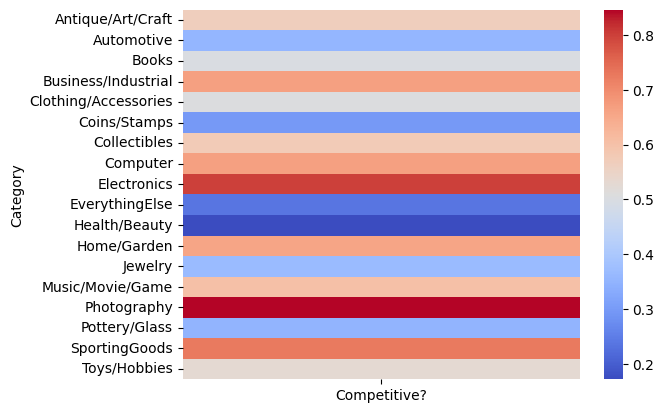

In [4]:
# 시각화 (seaborn 라이브러리 사용)
import seaborn as sns
import matplotlib.pyplot as plt

Category_pivot = eBayAuctions_df.pivot_table(index='Category', values='Competitive?', aggfunc='mean')
print(Category_pivot)
# heatmap 시각화
sns.heatmap(Category_pivot, cmap='coolwarm')
plt.show()

                                                    Competitive?
MergedCategory                                                  
Books+Clothing/Accessories+Toys/Hobbies+Antique...      0.564437
Coins/Stamps                                            0.297297
Electronics+Photography                                 0.808824
EverythingElse                                          0.235294
Health/Beauty                                           0.171875
Home/Garden+Computer+Business/Industrial                0.660256
Pottery/Glass+Automotive+Jewelry                        0.357143
SportingGoods                                           0.725806


/tmp/ipykernel_360516/3064287685.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_means = eBayAuctions_df.groupby("Category")["Competitive?"].mean()


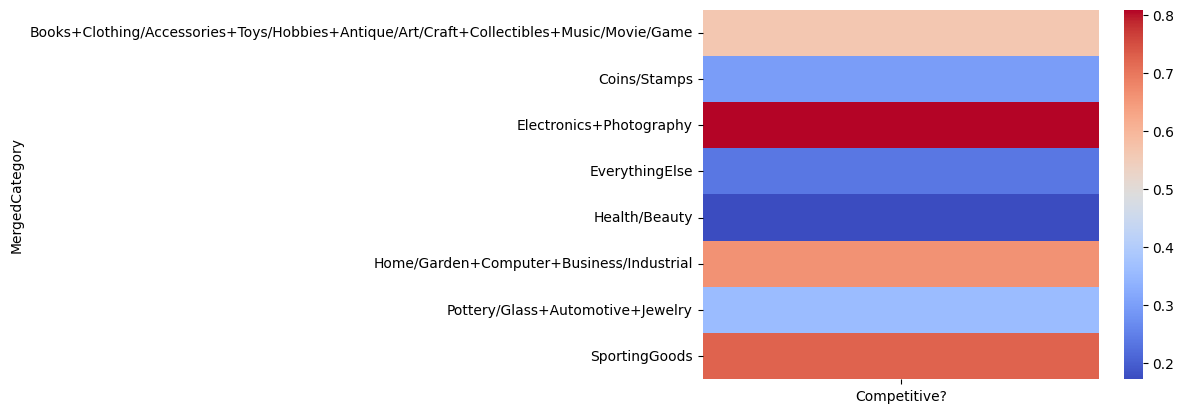

In [5]:
import pandas as pd
import numpy as np

# 데이터프레임 생성 (샘플 데이터)
eBayAuctions_df

# 범주별 평균값 계산
category_means = eBayAuctions_df.groupby("Category")["Competitive?"].mean()

# 오차 범위 내 병합을 위한 함수
def merge_categories(category_means, tolerance=0.05):
    category_means = category_means.sort_values()  # 오름차순 정렬
    groups = []  # 병합 결과 저장
    current_group = []
    current_mean = None

    for category, mean in category_means.items():
        if current_group and abs(current_mean - mean) > tolerance:
            groups.append(current_group)
            current_group = []
        current_group.append(category)
        current_mean = mean
    if current_group:
        groups.append(current_group)

    # 병합된 그룹 반환 (카테고리 이름들을 "-"로 연결)
    return {cat: "+".join(group) for group in groups for cat in group}

# 병합된 그룹 생성
merged_groups = merge_categories(category_means)

# 데이터프레임에 병합된 그룹 추가
eBayAuctions_df["MergedCategory"] = eBayAuctions_df["Category"].map(merged_groups)

merged_Category_pivot = eBayAuctions_df.pivot_table(index='MergedCategory', 
                                       values='Competitive?', 
                                       aggfunc='mean')
print(merged_Category_pivot)
# heatmap 시각화
sns.heatmap(merged_Category_pivot, cmap='coolwarm')
plt.show()

---
# currency(통화)
- EUR: 유로
- GBP: 파운드 스털링(영국 외 9개 국가)
- US: 달러

/tmp/ipykernel_360516/2085151041.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  currency_pivot = eBayAuctions_df.pivot_table(index='currency', values='Competitive?', aggfunc='mean')


          Competitive?
currency              
EUR           0.551595
GBP           0.687075
US            0.519350


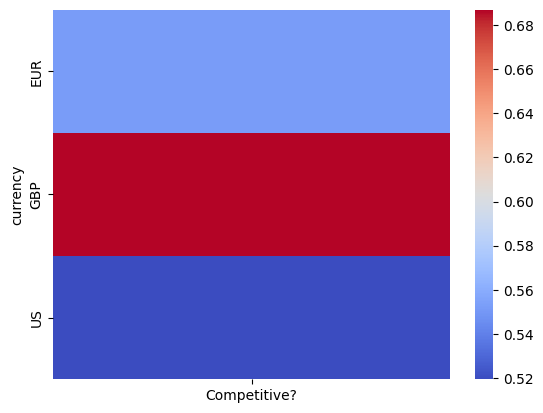

In [6]:
currency_pivot = eBayAuctions_df.pivot_table(index='currency', values='Competitive?', aggfunc='mean')
print(currency_pivot)
# heatmap 시각화
sns.heatmap(currency_pivot, cmap='coolwarm')
plt.show()

---
## endDay(경매 종료일)
- Monday
- Tuesday
- Wednsday
- Thursday
- Friday
- Saturday
- Sunday

/tmp/ipykernel_360516/2973017129.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  endDay_pivot = eBayAuctions_df.pivot_table(index='endDay', values='Competitive?', aggfunc='mean')


        Competitive?
endDay              
Fri         0.466899
Mon         0.673358
Sat         0.427350
Sun         0.485207
Thu         0.603960
Tue         0.532164
Wed         0.480000


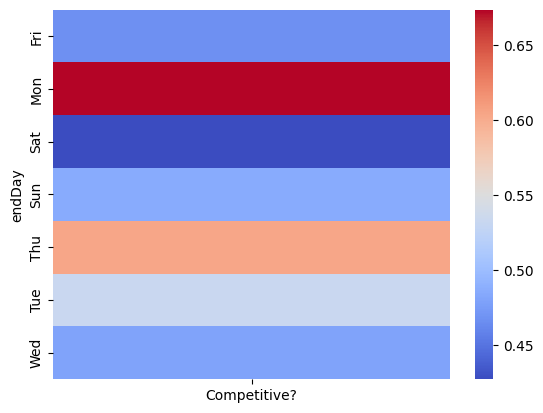

In [7]:
endDay_pivot = eBayAuctions_df.pivot_table(index='endDay', values='Competitive?', aggfunc='mean')
print(endDay_pivot)
# heatmap 시각화
sns.heatmap(endDay_pivot, cmap='coolwarm')
plt.show()

/tmp/ipykernel_360516/1627305626.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  endDay_means = eBayAuctions_df.groupby("endDay")["Competitive?"].mean()


               Competitive?
Merged_endDay              
Fri+Wed+Sun        0.477143
Mon                0.673358
Sat                0.427350
Thu                0.603960
Tue                0.532164


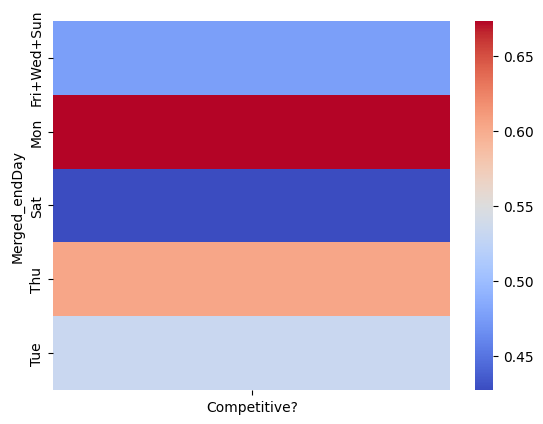

In [8]:
import pandas as pd
import numpy as np

eBayAuctions_df

# 범주별 평균값 계산
endDay_means = eBayAuctions_df.groupby("endDay")["Competitive?"].mean()

# 병합된 그룹 생성
merged_groups = merge_categories(endDay_means, 0.02)

# 데이터프레임에 병합된 그룹 추가
eBayAuctions_df["Merged_endDay"] = eBayAuctions_df["endDay"].map(merged_groups)

merged_endDay_pivot = eBayAuctions_df.pivot_table(index='Merged_endDay', 
                                                  values='Competitive?', 
                                                  aggfunc='mean')
print(merged_endDay_pivot)
# heatmap 시각화
sns.heatmap(merged_endDay_pivot, cmap='coolwarm')
plt.show()

---
## Duration(경매기간)
- 1
- 3
- 5
- 7
- 10

          Competitive?
Duration              
1             0.521739
3             0.450704
5             0.686695
7             0.489142
10            0.544554


/tmp/ipykernel_360516/1979901759.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  Duration_pivot = eBayAuctions_df.pivot_table(index='Duration', values='Competitive?', aggfunc='mean')


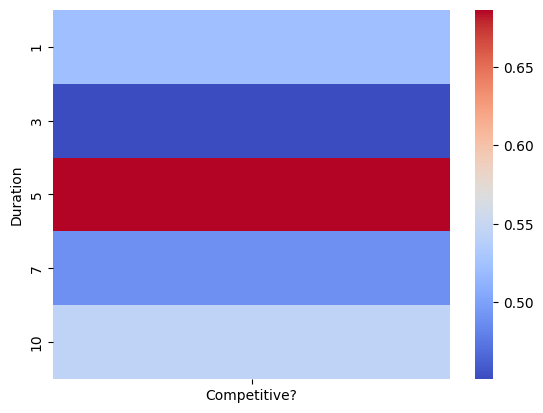

In [9]:
Duration_pivot = eBayAuctions_df.pivot_table(index='Duration', values='Competitive?', aggfunc='mean')
print(Duration_pivot)
# heatmap 시각화
sns.heatmap(Duration_pivot, cmap='coolwarm')
plt.show()

In [10]:
'''
범주형 예측 변수들에 대해서 더비 변수 생성
범주형 변수: Category, currency, endDay, Duration
'''
from sklearn.preprocessing import LabelEncoder

preprocessed_df = eBayAuctions_df.copy()
le = LabelEncoder()
preprocessed_df['Category'] = le.fit_transform(preprocessed_df['Category'])
preprocessed_df['currency'] = le.fit_transform(eBayAuctions_df['currency'])
preprocessed_df['endDay'] = le.fit_transform(eBayAuctions_df['endDay'])
preprocessed_df['Duration'] = le.fit_transform(eBayAuctions_df['Duration'])
preprocessed_df['MergedCategory'] = le.fit_transform(eBayAuctions_df['MergedCategory'])
preprocessed_df['Merged_endDay'] = le.fit_transform(eBayAuctions_df['Merged_endDay'])
preprocessed_df

,Category,currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?,MergedCategory,Merged_endDay
0,13,2,3249,2,1,0.01,0.01,0,0,1
1,13,2,3249,2,1,0.01,0.01,0,0,1
2,13,2,3249,2,1,0.01,0.01,0,0,1
3,13,2,3249,2,1,0.01,0.01,0,0,1
4,13,2,3249,2,1,0.01,0.01,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1967,1,2,2992,2,3,359.95,359.95,0,6,0
1968,1,2,21,2,2,610.00,300.00,1,6,2
1969,1,2,1400,2,1,549.00,549.00,0,6,1
1970,1,2,57,3,0,820.00,650.00,1,6,0


- 데이터를 학습 데이터셋(60%)과 검증 데이터셋(40%)으로 분할한다. 컷오프 값을 0.5로 하여 모든 예측 변수들을 사용한 로지스틱 모델을 실행하시오.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from dmba.metric import AIC_score
from dmba import classificationSummary

original_df = pd.read_csv('../data/eBayAuctions.csv')
y = original_df['Competitive?']
X = preprocessed_df.drop(['Competitive?'], axis=1)
#X = X.drop(['Group'], axis=1)
X = X.drop(['MergedCategory'], axis=1)
X = X.drop(['Merged_endDay'], axis=1)
print(X.columns)

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y,
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

logit_reg_pred = logit_reg.predict(valid_X)
# logit_reg_proba = logit_reg.predict_proba(valid_X)
cutoff = 0.5  # 원하는 cutoff 값 설정
logit_reg_pred = (logit_reg.predict_proba(valid_X)[:, 1] >= cutoff).astype(int)

logit_result = pd.DataFrame({'actual': valid_y,
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

print(logit_result)

classificationSummary(train_y, logit_reg.predict(train_X))
classificationSummary(valid_y, logit_reg.predict(valid_X))

Index(['Category', 'currency', 'sellerRating', 'Duration', 'endDay',
       'ClosePrice', 'OpenPrice'],
      dtype='object')
intercept  -0.16706945835727025
       Category  currency  sellerRating  Duration    endDay  ClosePrice  \
coeff  0.028273  0.134353     -0.000039  -0.07814 -0.087013    0.085669   

       OpenPrice  
coeff  -0.106675  

AIC 1077.8325172503298
      actual      p(0)      p(1)  predicted
1287       0  0.735907  0.264093          0
1017       1  0.143569  0.856431          1
1047       0  0.593302  0.406698          0
108        1  0.337761  0.662239          1
1084       1  0.573069  0.426931          0
...      ...       ...       ...        ...
1118       1  0.551180  0.448820          0
395        0  0.656183  0.343817          0
1564       0  0.705225  0.294775          0
1698       1  0.034092  0.965908          1
1665       1  0.040915  0.959085          1

[789 rows x 4 columns]
Confusion Matrix (Accuracy 0.7811)

       Prediction
Actual   0   1
     0 4

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from dmba.metric import AIC_score

original_df = pd.read_csv('../data/eBayAuctions.csv')
y = original_df['Competitive?']
X = preprocessed_df.drop(['Competitive?'], axis=1)
#X = X.drop(['Group'], axis=1)
X = X.drop(['Category'], axis=1)
X = X.drop(['endDay'], axis=1)
print(X.columns)


# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y,
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

logit_reg_pred = logit_reg.predict(valid_X)
# logit_reg_proba = logit_reg.predict_proba(valid_X)
cutoff = 0.5  # 원하는 cutoff 값 설정
logit_reg_pred = (logit_reg.predict_proba(valid_X)[:, 1] >= cutoff).astype(int)

logit_result = pd.DataFrame({'actual': valid_y,
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

print(logit_result)

classificationSummary(train_y, logit_reg.predict(train_X))
classificationSummary(valid_y, logit_reg.predict(valid_X))

Index(['currency', 'sellerRating', 'Duration', 'ClosePrice', 'OpenPrice',
       'MergedCategory', 'Merged_endDay'],
      dtype='object')
intercept  -0.13174189885819393
       currency  sellerRating  Duration  ClosePrice  OpenPrice  \
coeff  0.183455     -0.000025 -0.097935    0.087315  -0.107493   

       MergedCategory  Merged_endDay  
coeff       -0.076194       0.051781  

AIC 968.0059815539321
      actual      p(0)      p(1)  predicted
1287       0  0.656828  0.343172          0
1017       1  0.222385  0.777615          1
1047       0  0.538955  0.461045          0
108        1  0.355536  0.644464          1
1084       1  0.393540  0.606460          1
...      ...       ...       ...        ...
1118       1  0.495158  0.504842          1
395        0  0.671555  0.328445          0
1564       0  0.688567  0.311433          0
1698       1  0.018991  0.981009          1
1665       1  0.043563  0.956437          1

[789 rows x 4 columns]
Confusion Matrix (Accuracy 0.7811)

       

- 경매가 경쟁적인 경매인지 아닌지를 경매 시작 시점에서 예측하길 원한다면 경매 종가에 대한 정보를 사용할 수 없다. 경매 종가를 제외한 모든 예측변수를 이용해 앞에서와 같이 로지스틱 모델을 실행하시오. 이러한 모델은 예측 정확도 관점에서 모든 예측변수를 사용한 모델과 어떻게 비교되는가?

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from dmba.metric import AIC_score

original_df = pd.read_csv('../data/eBayAuctions.csv')
y = original_df['Competitive?']
X = preprocessed_df.drop(['Competitive?'], axis=1)
#X = X.drop(['Group'], axis=1)
X = X.drop(['MergedCategory'], axis=1)
X = X.drop(['Merged_endDay'], axis=1)
X = X.drop(['ClosePrice'], axis=1)
print(X.columns)

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y,
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

logit_reg_pred = logit_reg.predict(valid_X)
# logit_reg_proba = logit_reg.predict_proba(valid_X)
cutoff = 0.5  # 원하는 cutoff 값 설정
logit_reg_pred = (logit_reg.predict_proba(valid_X)[:, 1] >= cutoff).astype(int)

logit_result = pd.DataFrame({'actual': valid_y,
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

print(logit_result)

classificationSummary(train_y, logit_reg.predict(train_X))
classificationSummary(valid_y, logit_reg.predict(valid_X))

Index(['Category', 'currency', 'sellerRating', 'Duration', 'endDay',
       'OpenPrice'],
      dtype='object')
intercept  0.17041662846762867
       Category  currency  sellerRating  Duration    endDay  OpenPrice
coeff  0.032927  -0.00092      -0.00001 -0.023754 -0.057331  -0.009359

AIC 1586.2335897856806
      actual      p(0)      p(1)  predicted
1287       0  0.537497  0.462503          0
1017       1  0.414975  0.585025          1
1047       0  0.485090  0.514910          1
108        1  0.387093  0.612907          1
1084       1  0.551918  0.448082          0
...      ...       ...       ...        ...
1118       1  0.485090  0.514910          1
395        0  0.437302  0.562698          1
1564       0  0.437554  0.562446          1
1698       1  0.542746  0.457254          0
1665       1  0.399789  0.600211          1

[789 rows x 4 columns]
Confusion Matrix (Accuracy 0.5934)

       Prediction
Actual   0   1
     0 200 353
     1 128 502
Confusion Matrix (Accuracy 0.5716)

    

- 경매 종가에 대한 회귀 계수의 의미를 해석하시오. 경매 종가는 실질적인 의미가 있는가? 경매 종가를 이용해 경쟁적인 경매를 예측하는 것이 통계적으로 의미가 있는가? (유의수준 10% 사용)

- [6장 다중선형회귀]에서 설명한 대로 단계적 회귀(stepwise regression)를 사용해 학습 데이터셋에 가장 잘 적합된(정확도가 가장 높은) 모델을 찾으시오. 어떤 예측변수가 사용되는가?

In [14]:
import statsmodels.api as sm
import time
import warnings
warnings.filterwarnings("ignore")
def stepwise_selection(data_x, data_y):
    # 초기화
    startpoint = time.time()
    selected_features = []
    best_aic = float("inf")  # 초기 AIC를 무한대로 설정
    loopCount = 0

    while True:
        added = None
        removed = None
        # Forward Selection
        for feature in data_x.columns:
            if feature not in selected_features:
                temp_features = selected_features + [feature]
                
                model = sm.Logit(data_y, sm.add_constant(data_x[temp_features])).fit(method = 'bfgs')
                aic = model.aic
                if aic < best_aic:
                    best_aic = aic
                    added = feature
                    
                    
        # Backward Elimination
        if len(selected_features) > 0:
            for feature in selected_features:
                temp_features = [f for f in selected_features if f != feature]
                model = sm.Logit(data_y, sm.add_constant(data_x[temp_features])).fit(method = 'bfgs')
                aic = model.aic
                if aic < best_aic:
                    best_aic = aic
                    removed = feature
        if added is not None:
            selected_features.append(added)
        elif removed is not None:
            selected_features.remove(removed)
        else:
            break
        time.sleep(1)
        loopCount += 1
    #print("Best selected features:", selected_features)
    #print("Best AIC:", best_aic)

    return selected_features

In [15]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import statsmodels.api as sm

original_df = pd.read_csv('../data/eBayAuctions.csv')
y = original_df['Competitive?']
X = preprocessed_df.drop(['Competitive?'], axis=1)
X = X.drop(['Category'], axis=1)
X = X.drop(['endDay'], axis=1)
X = X.drop(['ClosePrice'], axis=1)
print(X.columns)

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
# partition data
selected_features = stepwise_selection(train_X, train_y)
print(selected_features)

# Fit Final Model
final_model = LogisticRegression()
final_model.fit(train_X[selected_features], train_y)
print("Final Model Coefficients:", final_model.coef_)

Index(['currency', 'sellerRating', 'Duration', 'OpenPrice', 'MergedCategory',
       'Merged_endDay'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.690917
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 13
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.690724
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.682771
         Iterations: 8
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.690244
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function

- 검증 데이터셋에서 가장 정확도가 높은 모델을 찾기 위해 단계적 회귀(stepwise regression)를 사용하시오. 어떤 예측변수가 사용되는가?

In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import statsmodels.api as sm

original_df = pd.read_csv('../data/eBayAuctions.csv')
y = original_df['Competitive?']
X = preprocessed_df.drop(['Competitive?'], axis=1)
X = X.drop(['Category'], axis=1)
X = X.drop(['endDay'], axis=1)
X = X.drop(['ClosePrice'], axis=1)
print(X.columns)

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
# partition data
selected_features = stepwise_selection(train_X, train_y)
print(selected_features)

# Fit Final Model
final_model = LogisticRegression()
final_model.fit(valid_X[selected_features], valid_y)
print("Final Model Coefficients:", final_model.coef_)

Index(['currency', 'sellerRating', 'Duration', 'OpenPrice', 'MergedCategory',
       'Merged_endDay'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.690917
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 13
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.690724
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.682771
         Iterations: 8
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.690244
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function

In [31]:
'''
stepwise_selection with the example(Chapter_06_linear_regression.ipynb)
'''

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from dmba import stepwise_selection

predictors = ['MergedCategory', 'currency', 'Duration', 'Merged_endDay', 'ClosePrice', 'OpenPrice', 'sellerRating']
outcome = 'Competitive?'

X = pd.get_dummies(eBayAuctions_df[predictors])
y = eBayAuctions_df[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)


def train_model(variables):
    if len(variables) == 0:
        return None
    model = LogisticRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [int(train_y.mean())] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = stepwise_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

train_X = train_X[best_variables]
valid_X = valid_X[best_variables]

pd.set_option('display.width', 95)
pd.set_option('display.precision',3)
pd.set_option('display.max_columns', 50)
print('intercept ', best_model.intercept_[0])

print(pd.DataFrame({'coeff': best_model.coef_[0]}, index=best_variables).transpose())
print()
print('AIC', AIC_score(valid_y, best_model.predict(valid_X), df = len(best_variables) + 1))
classificationSummary(valid_y, best_model.predict(valid_X))
pd.reset_option('display.width')
pd.reset_option('display.precision')
pd.reset_option('display.max_columns')

Variables: ClosePrice, OpenPrice, sellerRating, MergedCategory_Books+Clothing/Accessories+Toys/Hobbies+Antique/Art/Craft+Collectibles+Music/Movie/Game, MergedCategory_Coins/Stamps, MergedCategory_Electronics+Photography, MergedCategory_EverythingElse, MergedCategory_Health/Beauty, MergedCategory_Home/Garden+Computer+Business/Industrial, MergedCategory_Pottery/Glass+Automotive+Jewelry, MergedCategory_SportingGoods, currency_EUR, currency_GBP, currency_US, Duration_1, Duration_3, Duration_5, Duration_7, Duration_10, Merged_endDay_Fri+Wed+Sun, Merged_endDay_Mon, Merged_endDay_Sat, Merged_endDay_Thu, Merged_endDay_Tue
Start: score=2615.81, constant
Step: score=2245.77, add ClosePrice
Step: score=1641.46, add OpenPrice


Step: score=1481.04, add MergedCategory_Books+Clothing/Accessories+Toys/Hobbies+Antique/Art/Craft+Collectibles+Music/Movie/Game
Step: score=1306.83, add Merged_endDay_Fri+Wed+Sun
Step: score=1266.34, add MergedCategory_Coins/Stamps
Step: score=1266.34, unchanged None
['ClosePrice', 'OpenPrice', 'MergedCategory_Books+Clothing/Accessories+Toys/Hobbies+Antique/Art/Craft+Collectibles+Music/Movie/Game', 'Merged_endDay_Fri+Wed+Sun', 'MergedCategory_Coins/Stamps']
intercept  -0.44709511897064996
       ClosePrice  OpenPrice  \
coeff       0.082     -0.098   

       MergedCategory_Books+Clothing/Accessories+Toys/Hobbies+Antique/Art/Craft+Collectibles+Music/Movie/Game  \
coeff                                              0.447                                                        

       Merged_endDay_Fri+Wed+Sun  MergedCategory_Coins/Stamps  
coeff                     -0.398                       -0.897  

AIC 905.5347915246455
Confusion Matrix (Accuracy 0.8188)

       Prediction
Actual   

stepwise_selection을 통해 선택된 변수들은 다음과 같다.
* ClosePrice
* OpenPrice
* MergedCategory_Books+Clothing/Accessories+Toys/Hobbies+Antique/Art/Craft+Collectibles+Music/Movie/Game
* Merged_endDay_Fri+Wed+Sun
* MergedCategory_Coins/Stamps

Books+Clothing/Accessories+Toys/Hobbies+Antique/Art/Craft+Collectibles+Music/Movie/Game 항목일 경우 경매가 경쟁적이며, Merged_endDay_Fri+Wed+Sun, MergedCategory_Coins/Stamps에 속할 경우 경매가 덜 경쟁적이다.

# Part III

### - 학습 데이터셋에 L1 페널티가 있는 벌점화(regularized) 로지스틱 회귀를 사용한다. 이 결과(예측변수와 분류 성능)를, 가장 잘 적합한 모델 및 가장 잘 예측한 모델의 결과와 비교하시오.

-------------------- Best model -------------------------
intercept  -0.44709511897064996
       ClosePrice  OpenPrice  \
coeff       0.082     -0.098   

       MergedCategory_Books+Clothing/Accessories+Toys/Hobbies+Antique/Art/Craft+Collectibles+Music/Movie/Game  \
coeff                                              0.447                                                        

       Merged_endDay_Fri+Wed+Sun  MergedCategory_Coins/Stamps  
coeff                     -0.398                       -0.897  

AIC 905.5347915246455
Confusion Matrix (Accuracy 0.8188)

       Prediction
Actual   0   1
     0 333  20
     1 123 313
-------------------- L1-Regularized model -------------------------
       ClosePrice  OpenPrice  \
coeff       0.082     -0.098   

       MergedCategory_Books+Clothing/Accessories+Toys/Hobbies+Antique/Art/Craft+Collectibles+Music/Movie/Game  \
coeff                                              0.443                                                        

       M

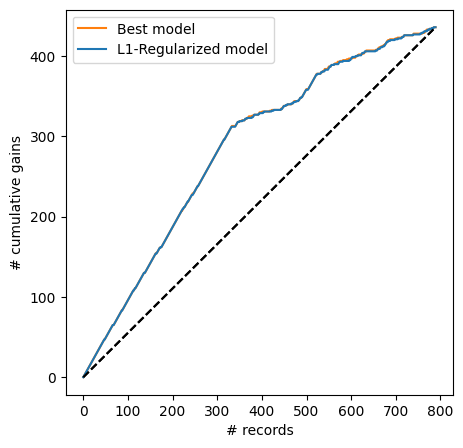

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from dmba.metric import AIC_score
from dmba import classificationSummary, gainsChart

predictors = ['MergedCategory', 'currency', 'Duration', 'Merged_endDay', 'ClosePrice', 'OpenPrice', 'sellerRating']
outcome = 'Competitive?'

X = pd.get_dummies(eBayAuctions_df[predictors])[best_variables]
y = eBayAuctions_df[outcome]

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

print('-'*20, 'Best model', '-'*25)
# logit_best = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
# logit_best.fit(train_X, train_y)
logit_best = best_model

logit_best_proba = logit_best.predict_proba(valid_X)
best_result = pd.DataFrame({'actual': valid_y,
                            'p(0)': [p[0] for p in logit_best_proba],
                            'p(1)': [p[1] for p in logit_best_proba],
                            'predicted': logit_best.predict(valid_X),
                          })
best_result = best_result.sort_values(by=['p(1)'], ascending=False)


pd.set_option('display.width', 95)
pd.set_option('display.precision',3)
pd.set_option('display.max_columns', 50)
print('intercept ', logit_best.intercept_[0])

print(pd.DataFrame({'coeff': logit_best.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_best.predict(valid_X), df=len(train_X.columns) + 1))
classificationSummary(best_result['actual'], best_result['predicted'])


print('-'*20, 'L1-Regularized model', '-'*25)
logit_l1 = LogisticRegression(penalty="l1", C=1e42, solver='liblinear')
logit_l1.fit(train_X, train_y)

logit_l1_proba = logit_l1.predict_proba(valid_X)
l1_result = pd.DataFrame({'actual': valid_y,
                            'p(0)': [p[0] for p in logit_l1_proba],
                            'p(1)': [p[1] for p in logit_l1_proba],
                            'predicted': logit_l1.predict(valid_X),
                          })
l1_result = l1_result.sort_values(by=['p(1)'], ascending=False)


print(pd.DataFrame({'coeff': logit_l1.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_l1.predict(valid_X), df=len(train_X.columns) + 1))
pd.reset_option('display.width')
pd.reset_option('display.precision')
pd.reset_option('display.max_columns')

classificationSummary(l1_result['actual'], l1_result['predicted'])

ax = gainsChart(best_result.actual, label='Best model', color='C1', figsize=[5, 5])
ax = gainsChart(l1_result.actual, label='L1-Regularized model', color='C0', ax=ax)
ax.legend()

plt.show()

동일한 조건에서 벌점화를 L1으로 바꿀 경우, 기존의 가장 잘 적합한 모델보다 성능은 근소하게 낮다. 학습된 coefficient는 상당히 유사하나, 미묘한 차이가 8개의 false positive와 9개의 false negative가 추가되게 하였다. 이를 Cumulative Gain Chart로 표현하면 다음과 같다.

### - 모델 분석의 주목적이 정확한 분류라고 한다면, 어떤 컷오프 값이 사용되어야 하는가?

In [29]:

from sklearn.metrics import f1_score, accuracy_score

max_f1 = 0
max_acc = 0
for cutoff in np.arange(0.0, 1.0, 0.01):
    logit_best_pred = (logit_best.predict_proba(valid_X)[:, 1] >= cutoff).astype(int)
    f1 = f1_score(valid_y, logit_best_pred)
    if f1 > max_f1:
        max_f1 = f1
        max_f1_cutoff = cutoff

    acc = accuracy_score(valid_y, logit_best_pred)
    if acc > max_acc:
        max_acc = acc
        max_acc_cutoff = cutoff
        
print('AIC', AIC_score(valid_y, logit_best_pred, df = len(train_X.columns) + 1))
classificationSummary(valid_y, logit_best_pred)

print(f"{'score type':>10s} | {'score':>6s}(cutoff)")
print(f"{'acc':>10s} | {max_acc:.4f}({max_acc_cutoff})")
print(f"{'acc':>10s} | {max_f1:.4f}({max_f1_cutoff})")

AIC 1666.1950127402329
Confusion Matrix (Accuracy 0.5247)

       Prediction
Actual   0   1
     0 352   1
     1 374  62
score type |  score(cutoff)
       acc | 0.8188(0.5)
       acc | 0.8140(0.5)


정확한 분류라는 정의가 모호하다. 일반적으로는 validation set에 대한 accuracy를 의미하나, bool 변수인 Competitive?의 비율이 동일하지 않으므로, f1 score 역시 분석한다.
 * accuracy의 최적 cutoff는 0.50으로 score는 약 0.8188
 * f1의 최적 cutoff는 0.50으로 score는 약 0.8140


### - 이 데이터를 바탕으로 판매자가 정한 경매 조건(경매 기간, 시작가, 경매 마감 요일, 화폐 단위) 중 어떤 설정이 경쟁적인 판매로 이어질 가능성을 가장 높인다고 할 수 있겠는가?

In [20]:
seller_setting = ['Duration', 'OpenPrice', 'Merged_endDay', 'currency']

X = pd.get_dummies(eBayAuctions_df[predictors])
y = eBayAuctions_df[outcome]

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

logit_best = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_best.fit(train_X, train_y)

logit_best_proba = logit_best.predict_proba(valid_X)
best_result = pd.DataFrame({'actual': valid_y,
                            'p(0)': [p[0] for p in logit_best_proba],
                            'p(1)': [p[1] for p in logit_best_proba],
                            'predicted': logit_best.predict(valid_X),
                          })
best_result = best_result.sort_values(by=['p(1)'], ascending=False)


pd.set_option('display.width', 95)
pd.set_option('display.precision',3)
pd.set_option('display.max_columns', 50)
print('intercept ', logit_best.intercept_[0])

print(pd.DataFrame({'coeff': logit_best.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_best.predict(valid_X), df=len(train_X.columns) + 1))
pd.reset_option('display.width')
pd.reset_option('display.precision')
pd.reset_option('display.max_columns')

intercept  -0.3159136046700574
       ClosePrice  OpenPrice  \
coeff       0.083     -0.099   

       MergedCategory_Books+Clothing/Accessories+Toys/Hobbies+Antique/Art/Craft+Collectibles+Music/Movie/Game  \
coeff                                              0.627                                                        

       MergedCategory_Coins/Stamps  MergedCategory_Electronics+Photography  \
coeff                       -1.474                                   1.403   

       MergedCategory_EverythingElse  MergedCategory_Health/Beauty  \
coeff                         -0.886                        -1.244   

       MergedCategory_Home/Garden+Computer+Business/Industrial  \
coeff                                              0.783         

       MergedCategory_Pottery/Glass+Automotive+Jewelry  MergedCategory_SportingGoods  \
coeff                                            0.056                          0.42   

       currency_EUR  currency_GBP  currency_US  Duration_1  Duration_

판매자가 설정할 수 있는 항목 중 통화는 GBP(1.23), 기간은 5일(0.217), 마감일은 Mon(0.543), 시작가는 낮게(-0.099) 시작할수록 경쟁적인 판매로 이어질 가능성이 높다.